In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm

def adjust_feature(feature_matrix, feature_id):
    c, f = feature_matrix.shape
    feature_matrix = feature_matrix.copy().todense()
    
    for i in np.arange(f):
        feature_umi_array = np.asarray(feature_matrix[:,i]).squeeze()

        feature_umi_array_sort = feature_umi_array[np.argsort(feature_umi_array * -1)]
        feature_cumsum = np.cumsum(feature_umi_array_sort)

        cell_num = np.sum(feature_umi_array_sort > 0)

        turn_point = np.sum(np.diff(feature_cumsum) / np.sum(feature_umi_array) > (1 / cell_num))
        feature_matrix[np.where(feature_umi_array < feature_umi_array_sort[turn_point]), i] = 0
        
    return feature_matrix

In [2]:
working_dir = ''

In [3]:
ds = sc.read_10x_h5(working_dir + 'filtered_feature_bc_matrix.h5', gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
ds.var_names_make_unique()

In [5]:
ds.obs_names_make_unique()

### Filter Data

In [6]:
#get the batches
batches = set()
for bc in ds.obs.index:
    bc_seq, batch_id = bc.split('-')
    batches.update(batch_id)

In [7]:
antibody_label = np.zeros_like(ds.obs.index)

In [8]:
#process the antibody
antibody_id = ['BC_H1', 'BC_H2', 'BC_H3', 'BC_H4', 'BC_H5', 'BC_H6', 'BC_H7', 'BC_H8', 'BC_H9', 'BC_H10']

#correct the antibody feature within each batch

for batch in batches:
    print("Processing Batch-" + batch + "...")
    #get the batch cell barrcodes
    batch_index = [i for i, bc in enumerate(ds.obs.index) if bc.endswith(str(batch))]
    
    #get the antibody feature index and filterr the matrix
    antibody_index = ds.var.feature_types.index[ds.var.feature_types == 'Antibody Capture'].tolist()
    antibody_adata = ds[:, antibody_index][batch_index, :]
    
    #adjust feature based on the slope method
    feature_matrix = adjust_feature(antibody_adata.X, antibody_id)
    
    batch_singlet_idx = np.argwhere(np.sum(feature_matrix > 0, axis=1) == 1)[:,0]
    
    for i in range(10):
        cell_count = np.sum(feature_matrix[:,i] > 0)
        singlet_idx = np.intersect1d(batch_singlet_idx, np.argwhere(feature_matrix[:,i] > 0)[:,0])
        
        batch_ab_singlet = np.array(batch_index)[singlet_idx]
        
        antibody_label[batch_ab_singlet] = (i + 1)

Processing Batch-4...
Processing Batch-2...
Processing Batch-6...
Processing Batch-3...
Processing Batch-7...
Processing Batch-8...
Processing Batch-1...
Processing Batch-5...


In [9]:
all_singlet_idx = np.asarray(np.argwhere(antibody_label > 0)).squeeze()
ds = ds[all_singlet_idx, :]

In [10]:
#merget gene index
c_num, g_num = ds.X.shape

all_singlet_idx = np.asarray(ds.obs.index)


#get the high mito cells
mt_index = ds.var.index[ds.var.index.str.startswith('MT-')].tolist()
mt_expr = np.sum(ds[:,mt_index].X, axis=1)
depth = np.sum(ds.X, axis=1)
high_mito_idx = np.argwhere((mt_expr / depth) > 0.2)[:,0].squeeze()

#get the gene and cell index
chosen_cell_index = np.setdiff1d(all_singlet_idx, all_singlet_idx[high_mito_idx])

#filter the matrix
adata = ds[chosen_cell_index, :]

sc.pp.filter_genes(adata, min_counts=1)         # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all') # normalize with total UMI count per cell # select highly-variable genes  # subset the genes


sc.pp.log1p(adata)
adata.raw = adata
sc.pp.scale(adata) 

Trying to set attribute `.var` of view, copying.


Text(0.5, 0, 'Mito Gene Expr (log10)')

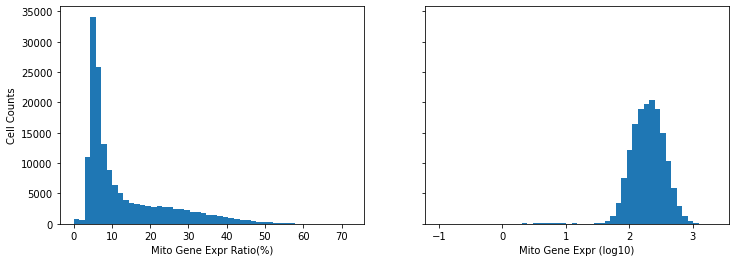

In [11]:
## check the mito gene expr
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4), sharey=True)
ax1.hist(mt_expr / depth * 100, bins=50)
ax1.set_xlabel('Mito Gene Expr Ratio(%)')
ax1.set_ylabel('Cell Counts')

ax2.hist(np.log10(mt_expr+0.1), bins=50)
ax2.set_xlabel('Mito Gene Expr (log10)')

In [12]:
adata.obs['library_name'] = [''] * adata.X.shape[0]
for cell_index in adata.obs.index:
    if cell_index.split('-')[-1] == '1':
        adata.obs['library_name'][cell_index] = 'DAA243'
    elif cell_index.split('-')[-1] == '2':
        adata.obs['library_name'][cell_index] = 'DAA244'
    elif cell_index.split('-')[-1] == '3':
        adata.obs['library_name'][cell_index] = 'DAA245'
    elif cell_index.split('-')[-1] == '4':
        adata.obs['library_name'][cell_index] = 'DAA246'
    elif cell_index.split('-')[-1] == '5':
        adata.obs['library_name'][cell_index] = 'DAA247'
    elif cell_index.split('-')[-1] == '6':
        adata.obs['library_name'][cell_index] = 'DAA248'
    elif cell_index.split('-')[-1] == '7':
        adata.obs['library_name'][cell_index] = 'DAA249'
    else:
        adata.obs['library_name'][cell_index] = 'DAA250'

### Load and Remove SG Cells

In [13]:
SG_DF = pd.read_pickle('./DAP3_SGRNA_IND_072821.pkl')

In [14]:
SG_DF_Grouped = pd.read_pickle('./DAP3_SGRNA_GROUP_072821.pkl')

In [15]:
sg_pos = []
for cell in adata.obs.index:
    try:
        if sum(SG_DF.loc[cell] > 0) > 0:
            sg_pos.append(cell)
    except:
        continue
adata = adata[sg_pos]

### Cluster Cells

In [16]:
sc.tl.pca(adata, random_state= 0)

In [17]:
sc.pp.neighbors(adata,use_rep='X_pca',random_state = 0)

In [18]:
sc.tl.louvain(adata,resolution = 0.2,random_state = 0)

In [19]:
sc.tl.paga(
    adata,
    groups='louvain', 
)

... storing 'library_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


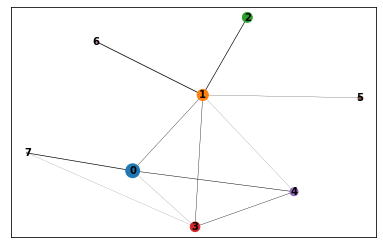

In [20]:
sc.pl.paga(
    adata, 
    color=['louvain'], 
    use_raw=True,
    layout='fr',
    threshold=0.01,
    node_size_scale=0.5,
    node_size_power=0.9,
    edge_width_scale=1,
)

In [21]:
sc.tl.umap(
    adata,
    init_pos='paga',
    random_state = 0
)

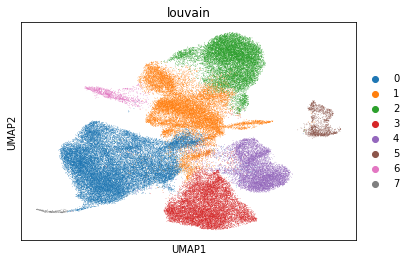

In [22]:
sc.pl.umap(
    adata,
    color=['louvain'], 
    vmin=0, vmax= 100
)

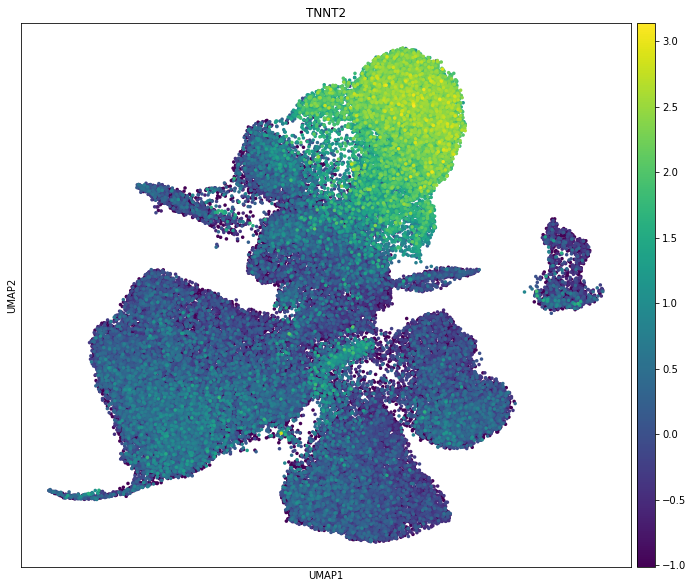

In [23]:
fig, ax = plt.subplots(figsize=(12,10))
sc.pl.umap(
    adata, 
    color=['TNNT2'],
        size=50,
            use_raw=False,
    ax=ax
)

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups(adata)

In [ ]:
adata.write('./DAP3_SC_072821.h5ad')